In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


<h2>Model Construction for On-Device Training</h2>

In [2]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

<h2>Fashion MNIST Data</h2>

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 4s 1us/step


<h2>Preprocess</h2>

In [4]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

In [5]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

<h2>Train Model</h2>

In [6]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

2022-01-09 22:33:02.472474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 22:33:02.472937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-09 22:33:02.677030: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Max


2022-01-09 22:33:02.677468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Finished 10 epochs
  loss: 0.424
Finished 20 epochs
  loss: 0.370
Finished 30 epochs
  loss: 0.335
Finished 40 epochs
  loss: 0.316
Finished 50 epochs
  loss: 0.302
Finished 60 epochs
  loss: 0.288
Finished 70 epochs
  loss: 0.275
Finished 80 epochs
  loss: 0.266
Finished 90 epochs
  loss: 0.258
Finished 100 epochs
  loss: 0.250


2022-01-09 22:37:12.532785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/model.ckpt'>}

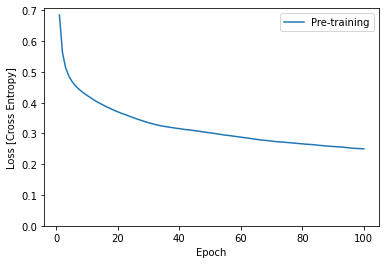

In [7]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

<h2>Convert to TfLite Format </h2>

In [8]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: saved_model/assets


2022-01-09 22:37:55.740628: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-01-09 22:37:56.012759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-09 22:37:56.012772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-09 22:37:56.012775: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-01-09 22:37:56.014196: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: saved_model
2022-01-09 22:37:56.015213: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-01-09 22:37:56.015218: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: saved_model
2022-01-09 22:37:56.017906: I tensorflow/cc/saved_model/loader.cc:210] Restor

<h2>Tflite Signiture</h2>

In [9]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

# Compare Original with TfLite
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

INFO: Created TensorFlow Lite delegate for select TF ops.
2022-01-09 22:40:04.447935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 22:40:04.447984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO: TfLiteFlexDelegate delegate: 0 nodes delegated out of 17 nodes with 0 partitions.

2022-01-09 22:40:04.452323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
